In [294]:
# Little Jupyter notebook to explore time series data from in situ stations and satellite observations,
# both already in csv format.

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# These two datasets are for the GCNet data
# os.chdir('/home/arthur/Dropbox/projects/greenland/station_data/appears_extraction')
# all_data_mcd = pd.read_csv('greenland-stations-MCD43A3-006-results.csv', index_col=0)
#
# os.chdir('/home/arthur/Dropbox/projects/greenland/station_data/tower_data/orig_data_std_format/')
# stn_df = pd.read_csv('Summit_06c.csv')

# This is the NOAA Summit stn data
os.chdir('/home/arthur/Dropbox/projects/greenland/station_data/noaa_summit_data')
stn_df = pd.read_csv('noaa_summit_all.csv')

# Raw Appears outputs
# os.chdir('/home/arthur/Dropbox/projects/greenland/station_data/appears_extraction/noaa_summit')
# all_data_mcd = pd.read_csv('noaa-summit-manual-location-MCD43A3-006-results.csv', index_col=0)

# Blue sky albedo outputs
os.chdir('/home/arthur/Dropbox/projects/greenland/station_data/appears_extraction/noaa_summit/blue_sky/')
all_data_mcd = pd.read_csv('MODIS_summit_2013-2019.csv', index_col=0)

# Column variables for readability
date = 'Date'
#mcd_variable = 'MCD43A3_006_Albedo_WSA_shortwave'
#mcd_qa = 'MCD43A3_006_BRDF_Albedo_Band_Mandatory_Quality_shortwave'

mcd_variable = 'MCD43_blue_sky_albedo'
mcd_qa = 'MCD43_QA'
# Specify whether to keep QA == 1, i.e. magnitude inversions

high_qa_only = True

In [295]:
# Subset and mask station data

# Valid dataset options: GCNET, NOAA
dataset = "NOAA"

if dataset == "GCNET":
    # Filter out non-noon observations from dataset
    #TODO Can't figure out why these two filters cannot be combined into single line
    filter = stn_df['dec_day'] % 0.5 == 0
    stn_df.where(filter, inplace = True)

    filter = stn_df['dec_day'] % 1.0 != 0
    stn_df.where(filter, inplace = True)

    # Remove observations filtered out above
    stn_df = stn_df.dropna()

    # Clean up dec_days and combine wit.h year to make new date field in yyyy-mm-dd, use as index
    stn_df['dec_day'] = stn_df['dec_day'].apply(np.floor)
    stn_df['dec_day'] = stn_df['dec_day'].astype(int).astype(str)
    stn_df['dec_day'] = stn_df['dec_day'].str.zfill(3)
    stn_df['date'] = stn_df['year'].astype(int).astype(str) + stn_df['dec_day']
    stn_df['date'] = pd.to_datetime(stn_df['date'], format='%Y%j')
    stn_df = stn_df.set_index(stn_df['date'])

    # Delete now unnecessary dateparts
    del stn_df['year']
    del stn_df['dec_day']

    # Set albedo fill values to NaN
    stn_df['alb'].mask(stn_df['alb'] == 999, np.NaN, inplace=True)
elif dataset == "NOAA":
    # Add column to contain entire date string
    stn_df['date'] = pd.to_datetime(stn_df['Year'].map(str) + "-" + stn_df['Mn'].map(str) + "-" + stn_df['Dy'].map(str))
    # + " " + stn_df['Hr'].map(str) + ":" + stn_df['Mi'].map(str))

    # Here, instead of selecting noon, create a pivot of the selection using Hr == 11 AND Hr == 12 to average alb
    df_selection = stn_df.loc[(stn_df['Hr'] == 11) | (stn_df['Hr'] == 12) ].copy()
    df_selection = pd.pivot_table(df_selection,index=['date'], aggfunc=[np.average],
                                  values=['U_GLOBAL', 'D_GLOBAL']).copy()

    # The below steps are taken from https://bit.ly/301hrH2 to return the pivot_table back to workable df
    df_selection.columns = df_selection.columns.droplevel(0)
    df_selection.columns.name = None
    df_selection = df_selection.reset_index()
    # Note the .copy() prevents the new variable from simply pointing to the original df

    #df_selection = df_selection.loc[(stn_df['Hr'] == 12) & (stn_df['Mi'] == 0)].copy()

    # Now that we have our combined date/time col, get rid of these
    # del df_selection['Year']
    # del df_selection['Mn']
    # del df_selection['Dy']
    # del df_selection['Hr']
    # del df_selection['Mi']
    #
    # # These are longwave radiation
    # del df_selection['D_IR']
    # del df_selection['U_IR']

    # Calculate "albedo" simply as the ratio of upward to downwelling radiance
    df_selection['alb'] = df_selection['U_GLOBAL'] / df_selection['D_GLOBAL']
    df_selection = df_selection.loc[(df_selection['U_GLOBAL'] > 0.0)]
    df_selection = df_selection.loc[(df_selection['D_GLOBAL'] > 0.0)]

    # Filter out spurious albedo values (sensor errors?)
    df_selection = df_selection.loc[(df_selection['alb'] < 1.0) & (df_selection['alb'] > 0.0)]

    df_selection = df_selection.set_index(df_selection['date'])
    # Set the selection back to the original df variable to fit into exisiting code.
    stn_df = df_selection.copy()
#print(stn_df.head())

/home/arthur/software/anaconda3/envs/geo/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/arthur/software/anaconda3/envs/geo/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [296]:
# Subset and mask mcd43 data
mcd_df = all_data_mcd.loc['noaasummit', [date, mcd_variable, mcd_qa]]

# Mask out fill values
mcd_df[mcd_variable].mask(mcd_df[mcd_qa] == 255, np.NaN, inplace=True)

# If specified, remove QA == 1
if high_qa_only:
    mcd_df[mcd_variable].mask(mcd_df[mcd_qa] == 1, np.NaN, inplace=True)

print(mcd_df.head())


                Date  MCD43_blue_sky_albedo  MCD43_QA
Category                                             
noaasummit  01/01/13                    0.0         0
noaasummit  01/02/13                    0.0         0
noaasummit  01/03/13                    0.0         0
noaasummit  01/04/13                    0.0         0
noaasummit  01/05/13                    NaN       255


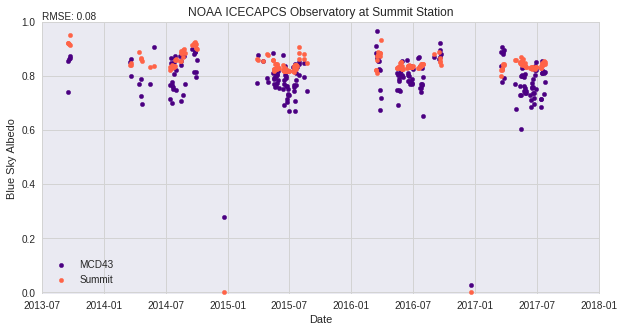

In [297]:
# Plot data
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

mcd_df[date] = pd.to_datetime(mcd_df[date], yearfirst=True)
mcd_df = mcd_df.set_index(mcd_df[date])

stn_df.set_index(stn_df['date'])

# Join satellite observations to stn data based on date
joined_df = mcd_df.join(stn_df, lsuffix='_mcd', rsuffix='_stn')

if dataset == "GCNET":
    #del joined_df['date']
    del joined_df[mcd_qa]
    del joined_df['sw_down']
    del joined_df['sw_up']
    del joined_df['net_rad']
    del joined_df['Date']
elif dataset == "NOAA":
    del joined_df[mcd_qa]
    del joined_df['Date']
    del joined_df['D_GLOBAL']
    del joined_df['U_GLOBAL']

# Subset dataset to correct time period (different for different stations?
joined_subset_df = joined_df.loc['2013-01-01':'2019-12-01']

# Calculate stats on dataset that has no missing values
joined_subset_no_nans_df = joined_subset_df.dropna()
sw_wsa_mse = mean_squared_error(joined_subset_no_nans_df[mcd_variable], joined_subset_no_nans_df['alb'])
sw_wsa_rmse = round(math.sqrt(sw_wsa_mse), 2)

# Add back in the missing days in a plottable way
joined_subset_no_nans_filled_df = joined_subset_no_nans_df.asfreq('D')
joined_subset_no_nans_filled_df.to_csv('final_data_test.csv')
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# Do plot
ax = joined_subset_no_nans_filled_df.plot(kind='scatter', x='date', y='alb', color='Indigo', label='MCD43')
ax.text(pd.Timestamp("2013-07-01"), 1.008, "RMSE: " + str(sw_wsa_rmse))
ax.set_ylim([-0.005,1.0])
ax.set_xlim([pd.Timestamp("2013-07-01"),pd.Timestamp("2018-01-05")])
ax.grid(b=True, which='major', color='LightGrey', linestyle='-')
ax.minorticks_on()

joined_subset_no_nans_filled_df.plot(kind='scatter', x='date', y=mcd_variable, ax=ax, color='Tomato', label='Summit',
                                     figsize=(10,5))
ax.legend(loc='lower left')
ax.set_xlabel('Date')
ax.set_ylabel('Blue Sky Albedo')
ax.set_title('NOAA ICECAPCS Observatory at Summit Station')

plt.savefig('summit_noaa_vs_mcd43_bluesky.png')
# joined_subset_df.plot(kind='scatter', y='alb', x='date', use_index=True)
# joined_subset_df.plot(kind='scatter', y=mcd_variable, x='date', use_index=True)
#
# # Export csv if needed
#joined_subset_no_nans_filled_df.to_csv('test_high_qa_only.csv')


